In [3]:
####################### IMPORTING ALL LIBRARIES #############################

# Core
import os
import json
import random
import itertools

# Math & Analysis
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Image Processing
from PIL import Image, ImageDraw

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Vision
import torchvision.models as models
import torchvision.transforms as transforms

# Machine Learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

# Similarity Search
import faiss

# Language Modeling
from typing import List
from anthropic import Anthropic
from huggingface_hub import InferenceClient


# HTTP Requests
import requests
from dotenv import load_dotenv

##########################################################################
# Setting working directory
# os.chdir("/Users/parsakeyvani/Downloads/spring-2025-final-project-project-group-4-1")
os.chdir("/Users/hannahkim/Desktop/SCHOOL/GEORGETOWN/DSAN-6725/spring-2025-final-project-project-group-4")
print("Current working directory:", os.getcwd())

Current working directory: /Users/hannahkim/Desktop/SCHOOL/GEORGETOWN/DSAN-6725/spring-2025-final-project-project-group-4


In [4]:
# color palette
color_palette = {"black", "white", "gray", "beige", "navy", "brown", "camel", "tan", "red", "burgundy", "pink", "blue", "denim", "green", "olive", "mustard", "orange", "purple", "pastel", "gold", "silver"}

👗 Welcome to your personal stylist, CASUAL!
🌡️ Current temperature: 11°C

🎯 Occasion detected: casual


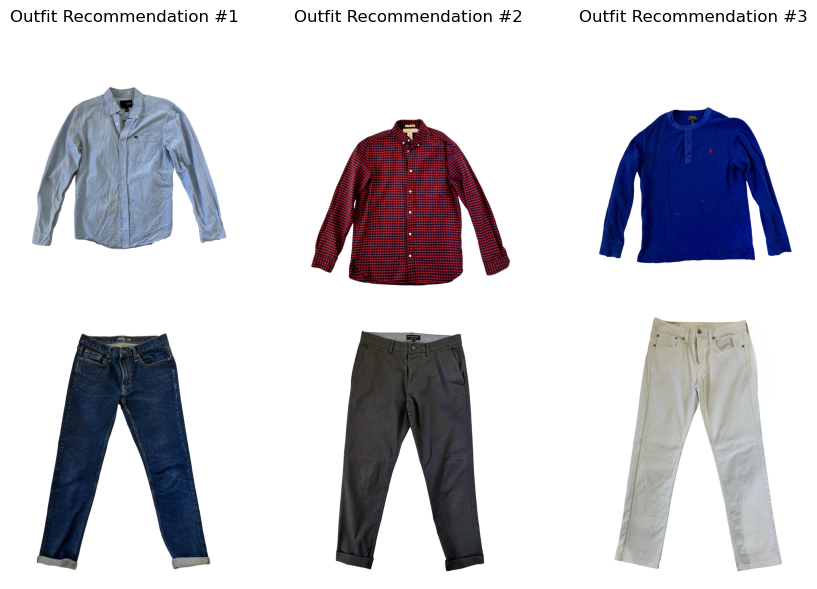


🧠 Your Personal Stylist Says:
Hey there! Okay, let's take a look at these outfits:

Outfit 1: This gives off a classic, slightly preppy vibe. The blue button-up and navy pants are a timeless combo that works well for casual occasions.

Outfit 2: This has a more refined, polished look. The light blue shirt and charcoal pants are a bit dressier, so this could work if you want to feel a bit more put-together.

Outfit 3: This is the most casual of the three. The blue tee and white pants have a laidback, relaxed feel to them. This is perfect if you want to feel super chill and comfortable.

For the 11°C weather, I'd go with Outfit 3. The lighter, airy pieces will keep you comfortable, and the casual vibe is perfect for a relaxed day. Plus, the white pants will look fresh and spring-like. Just throw on a light jacket or cardigan and you'll be good to go!

👋 Bye! Stay stylish.


In [19]:
load_dotenv() # get the api key from .env file
client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))
# huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")
# hf_client = InferenceClient(token=huggingface_api_key)

# Load clothing data and embeddings
with open("Parsa/testing_code/clothing_embeddings.json") as f:
    clothing_data = json.load(f)

metadata_list = []
embedding_list = []

for item in clothing_data:
    metadata_list.append({k: item[k] for k in item if k != "embedding"})
    embedding_list.append(item["embedding"])

embedding_array = np.array(embedding_list).astype("float32")

# Create FAISS index
embedding_dim = embedding_array.shape[1]
faiss_index = faiss.IndexFlatL2(embedding_dim)
faiss_index.add(embedding_array)

# Weather Tool
class WeatherTool:
    def __init__(self):
        self.api_key = "b6d172c255ac43e1ebfa3d041e1c454c"

    def get_temperature(self, city="Washington", country="US"):
        url = f"http://api.openweathermap.org/data/2.5/weather?q={city},{country}&appid={self.api_key}&units=metric"
        response = requests.get(url)
        data = response.json()
        if "main" in data:
            return round(data["main"]["temp"])
        else:
            raise ValueError(f"Failed to fetch weather data: {data}")
        

# Define a comprehensive color palette from metadata
def build_color_palette_from_metadata(metadata):
    colors = set()
    
    # Extract colors from all clothing items
    for category in metadata:
        for item in metadata[category]:
            if "color" in item:
                if isinstance(item["color"], list):
                    for color in item["color"]:
                        colors.add(color.lower())
                else:
                    colors.add(item["color"].lower())
    
    return sorted(list(colors))


# Parse user input for occasion and colors with specificity       
def parse_user_input(user_input, color_palette):
    user_input = user_input.lower()
    occasion = "casual"  # default

    if any(word in user_input for word in ["date", "romantic"]):
        occasion = "date night"
    elif any(word in user_input for word in ["interview", "meeting"]):
        occasion = "job interview"
    elif any(word in user_input for word in ["beach", "walk"]):
        occasion = "beach walk"
    elif any(word in user_input for word in ["chill", "weekend", "hang"]):
        occasion = "chill weekend hang"
    elif any(word in user_input for word in ["formal"]):
        occasion = "formal"
    elif any(word in user_input for word in ["gym", "run", "sporty"]):
        occasion = "sporty"
    
    # Parse color preferences
    detected_colors = []
    color_target = None  # Default to None, which means we need to ask for clarification
    
    for color in color_palette:
        if color in user_input:
            detected_colors.append(color)
            
    # Check if the user explicitly specified where to apply the color
    if any(word in user_input for word in ["top", "shirt", "t-shirt", "tshirt", "t shirt"]):
        if any(word + " and " in user_input or " and " + word in user_input for word in ["bottom", "pants", "shorts"]):
            color_target = "both"
        else:
            color_target = "top"
    elif any(word in user_input for word in ["bottom", "pants", "shorts", "pant", "short"]):
        if any(word + " and " in user_input or " and " + word in user_input for word in ["top", "shirt", "t-shirt"]):
            color_target = "both"
        else:
            color_target = "bottom"
    elif any(word in user_input for word in ["both", "everything", "all"]):
        color_target = "both"
    
    return {
        "occasion": occasion,
        "colors": detected_colors,
        "color_target": color_target
    }

# Parse user's color target clarification response
def parse_color_target_response(response):
    response = response.lower()
    
    if any(word in response for word in ["top", "shirt", "t-shirt", "tshirt", "t shirt", "upper"]):
        if any(word in response for word in ["bottom", "pants", "shorts", "pant", "short", "lower"]):
            return "both"
        return "top"
    elif any(word in response for word in ["bottom", "pants", "shorts", "pant", "short", "lower"]):
        return "bottom"
    elif any(word in response for word in ["both", "everything", "all", "entire", "outfit", "everywhere"]):
        return "both"
    
    # Default to "top" if we can't determine a clear preference
    return "top"

# Enhanced temperature-based outfit filtering with automatic sleeve recommendations
def filter_wardrobe(wardrobe, temperature, occasion, color_preferences=None, color_target=None):
    suitable = []
    
    # Temperature-based clothing recommendations
    is_cold = temperature < 15  # Cold: below 15°C
    is_cool = 15 <= temperature < 22  # Cool: 15-21°C
    is_warm = 22 <= temperature < 28  # Warm: 22-27°C
    is_hot = temperature >= 28  # Hot: 28°C and above
    
    # Determine recommended sleeve type based on temperature (but don't print it)
    if is_cold or is_cool:
        recommended_sleeve = "long"
    else:  # warm or hot
        recommended_sleeve = "short"
    
    for item in wardrobe:
        # Handle both string and list formats for item properties
        item_styles = item.get("style", [])
        if isinstance(item_styles, str):
            item_styles = [item_styles]
            
        item_color = item.get("color", "")
        sleeve_type = item.get("sleeve", "")
        
        # Convert item_color to a list for consistent handling
        if isinstance(item_color, str):
            item_color = [item_color.lower()]
        else:
            item_color = [c.lower() for c in item_color]
        
        # Check occasion match - look for any style that matches
        occasion_match = any(style.lower() == occasion.lower() for style in item_styles)
        
        # Temperature suitability check - prioritize recommended sleeve type for tops
        temp_suitable = True
        
        # For tops, check sleeve type against temperature recommendation
        if item["category"] in ["shirt", "t-shirt"]:
            if sleeve_type and sleeve_type != recommended_sleeve:
                temp_suitable = False  # Not the recommended sleeve type
        
        # For bottoms, filter out shorts in cold weather
        elif item["category"] == "shorts" and is_cold:
            temp_suitable = False  # Too cold for shorts
        
        # Add item if it meets all criteria
        if occasion_match and temp_suitable:
            suitable.append(item)
    
    # If we don't have enough suitable items with the recommended sleeve type,
    # try allowing both sleeve types but still respect the occasion
    if len([item for item in suitable if item["category"] in ["shirt", "t-shirt"]]) < 1:
        for item in wardrobe:
            item_styles = item.get("style", [])
            if isinstance(item_styles, str):
                item_styles = [item_styles]
                
            # Include all sleeve types that match the occasion
            if item["category"] in ["shirt", "t-shirt"] and any(style.lower() == occasion.lower() for style in item_styles):
                # Only add if not already in suitable list
                if item not in suitable:
                    suitable.append(item)
    
    # If color preferences exist and color target is specified, apply color filtering
    if color_preferences and len(color_preferences) > 0 and color_target is not None:
        color_filtered = []
        
        for item in suitable:
            item_category = item["category"]
            item_color = item.get("color", "")
            
            # Standardize color format
            if isinstance(item_color, str):
                item_color = [item_color.lower()]
            else:
                item_color = [c.lower() for c in item_color]
            
            # Check if this item's category should be color filtered
            should_filter = False
            if color_target == "both":
                should_filter = True
            elif color_target == "top" and item_category in ["shirt", "t-shirt"]:
                should_filter = True
            elif color_target == "bottom" and item_category in ["pants", "shorts"]:
                should_filter = True
            
            # If this item should be filtered by color
            if should_filter:
                # Check if any of the item's colors match any of the preferred colors
                if any(color.lower() in item_color for color in color_preferences):
                    color_filtered.append(item)
            else:
                # If this item category isn't subject to color filtering, include it
                color_filtered.append(item)
        
        # Replace suitable with color-filtered results
        suitable = color_filtered
    
    return suitable


# Generate Recommendations
def generate_outfit_recommendations(user_input, temperature, gender, outfits: List[List[dict]]):
    prompt = f"""
Hey, you're my stylish buddy helping me get dressed.
I'm a {gender} and I'm trying to figure out what to wear.

Here's the situation:
"{user_input}" (temperature is {temperature}°C)

Here are three outfit combos I'm considering:
"""

    for i, outfit in enumerate(outfits):
        prompt += f"\nOutfit {i+1}:\n{json.dumps(outfit, indent=2)}\n"

    prompt += """
For each one, tell me what kind of vibe it gives off — like if I want to feel chill, sporty, bold, etc.
Then give me your final verdict on which one to wear and why. Keep it casual and short, like we're texting.
"""

    try:
        # Correct way to use HuggingFace InferenceClient for text generation
        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=300,
            temperature=0.8,
            messages=[{"role": "user", "content": prompt}]
        )
        # response = hf_client.text_generation(
        #     prompt,
        #     model="mistralai/Mistral-7B-Instruct",
        #     max_new_tokens=300,
        #     temperature=0.8,
        #     repetition_penalty=1.1
        # )
        return [response]
    except Exception as e:
        print(f"Error with Hugging Face API: {e}")
        # Simple fallback response if API fails
        return ["Here's my take on these outfits: They all look good for different reasons. I'd go with outfit #1 because it seems to best match the occasion and weather. Let me know what you think!"]

def display_selected_outfit(outfits):
    category_folder_map = {
        "shirt": "shirts",
        "t-shirt": "t-shirts",
        "pants": "pants",
        "shorts": "shorts"
    }

    num_outfits = len(outfits)
    fig, axs = plt.subplots(2, num_outfits, figsize=(3 * num_outfits, 6), gridspec_kw={'hspace': 0.0})

    for col, outfit in enumerate(outfits):
        for row, item in enumerate(outfit):
            path = os.path.join("Parsa/parsa's_wardrobe", category_folder_map[item["category"]], item["filename"])
            img = Image.open(path).convert("RGB")
            axs[row, col].imshow(img)
            axs[row, col].axis("off")

    for col in range(num_outfits):
        axs[0, col].set_title(f"Outfit Recommendation #{col + 1}", fontsize=12, pad=10)

    plt.subplots_adjust(hspace=0)
    plt.tight_layout()
    plt.show()

# outfit_agent function
def outfit_agent(user_input, temperature, gender="female", refresh=False, lock_top=None, lock_bottom=None, color_palette=None, color_target_override=None):
    if color_palette is None:
        # Generate color palette from metadata if not provided
        with open("metadata.json") as f:
            metadata = json.load(f)
        color_palette = build_color_palette_from_metadata(metadata)
    
    # Parse user input for occasion and colors
    parsed_input = parse_user_input(user_input, color_palette)
    occasion = parsed_input["occasion"]
    color_preferences = parsed_input["colors"]
    
    # If color_target_override is provided, use it instead of what was parsed
    color_target = color_target_override if color_target_override is not None else parsed_input["color_target"]

    print(f"\n🎯 Occasion detected: {occasion}")

    # If the user mentioned a color but didn't specify where to apply it,
    # we need to ask for clarification
    if color_preferences and color_target is None and color_target_override is None:
        return {
            "need_clarification": True,
            "colors": color_preferences,
            "occasion": occasion,
            "user_input": user_input
        }
    
    if color_preferences:
        color_str = ", ".join(color_preferences)
        if color_target == "both":
            target_str = "the entire outfit"
        elif color_target == "top":
            target_str = "the top"
        else:
            target_str = "the bottom"
        print(f"🎨 Color preferences: {color_str} for {target_str}")

    # Filter wardrobe based on criteria (temperature, occasion, colors)
    filtered = filter_wardrobe(metadata_list, temperature, occasion, color_preferences, color_target)
    
    # Create separate lists for tops and bottoms
    all_tops = [item for item in filtered if item["category"] in ["shirt", "t-shirt"]]
    all_bottoms = [item for item in filtered if item["category"] in ["pants", "shorts"]]
    
    # Check if we have enough items for at least one outfit
    if len(all_tops) == 0 or len(all_bottoms) == 0:
        print("❌ No outfits matched your criteria. Try different colors or occasion.")
        return []
    
    # Apply refreshing if needed
    if refresh:
        random.shuffle(all_tops)
        random.shuffle(all_bottoms)

    # Create combinations
    combinations = []
    max_outfits = min(3, len(all_tops), len(all_bottoms))
    
    for i in range(max_outfits):
        top = lock_top if lock_top else all_tops[i % len(all_tops)]
        bottom = lock_bottom if lock_bottom else all_bottoms[i % len(all_bottoms)]
        combinations.append([top, bottom])

    if combinations:
        # Add temperature context to the recommendations
        temperature_context = f"For {temperature}°C weather, "
        enhanced_input = f"{temperature_context}{user_input}"
        
        responses = generate_outfit_recommendations(enhanced_input, temperature, gender, combinations)
        
        try:
            display_selected_outfit(combinations)
        except Exception as e:
            print(f"Error displaying outfits: {e}")

        for i, res in enumerate(responses):
            # Extract just the text content from the response
            if hasattr(res, 'content'):
                # If content is a list of blocks
                text_content = ""
                for block in res.content:
                    if hasattr(block, 'text'):
                        text_content += block.text
                print(f"\n\U0001F9E0 Your Personal Stylist Says:\n{text_content}\n")
            elif isinstance(res, str):
                # If response is already a string
                print(f"\n\U0001F9E0 Your Personal Stylist Says:\n{res}\n")
            else:
                # Try to extract text using a different approach
                print(f"\n\U0001F9E0 Your Personal Stylist Says:\n{res.text if hasattr(res, 'text') else str(res)}\n")
    else:
        print("❌ No outfit combinations could be created with available items.")

    return combinations


# chat_loop 
def chat_loop():
    combos = []
    locked_top = None
    locked_bottom = None
    pending_clarification = None

    # Load metadata and build color palette once at startup
    with open("metadata.json") as f:
        metadata = json.load(f)
    
    color_palette = build_color_palette_from_metadata(metadata)

    print("👗 Welcome to your personal stylist, CASUAL!")

    # Create weather tool and get initial temperature
    weather_tool = WeatherTool()
    cached_temperature = weather_tool.get_temperature("Washington", "US")
    print(f"🌡️ Current temperature: {cached_temperature}°C")

    while True:
        if pending_clarification:
            # We're waiting for clarification about where to apply colors
            color_str = ", ".join(pending_clarification["colors"])
            print(f"\n🤔 I noticed you want {color_str}. Where would you like to apply this color?")
            print("Please specify: top, bottom, or both outfit?")
            
            user_response = input("\n\U0001F464 You: ").strip()
            
            if user_response.lower() in ["exit", "quit", "bye"]:
                print("👋 Bye! Stay stylish.")
                break
                
            color_target = parse_color_target_response(user_response)
            
            if color_target == "top":
                print(f"✅ Applying {color_str} to the top only.")
            elif color_target == "bottom":
                print(f"✅ Applying {color_str} to the bottom only.")
            else:
                print(f"✅ Applying {color_str} to the entire outfit.")
                
            # Process the original request with the clarified color target
            combos = outfit_agent(
                pending_clarification["user_input"],
                temperature=cached_temperature,
                refresh=True,
                lock_top=locked_top,
                lock_bottom=locked_bottom,
                color_palette=color_palette,
                color_target_override=color_target
            )
            
            # Reset pending clarification
            pending_clarification = None
            continue
        
        user_input = input("\n\U0001F464 You: ").strip()

        if user_input.lower() in ["exit", "quit", "bye"]:
            print("👋 Bye! Stay stylish.")
            break

        # Command to update the weather
        if "update weather" in user_input.lower() or "check weather" in user_input.lower():
            try:
                cached_temperature = weather_tool.get_temperature("Washington", "US")
                print(f"🌡️ Current temperature: {cached_temperature}°C")
                continue
            except Exception as e:
                print(f"❌ Could not update weather: {e}")
                continue

        if "show colors" in user_input.lower() or "show me the colors" in user_input.lower() or "available colors" in user_input.lower():
            print(f"✨ Available colors: {', '.join(sorted(color_palette))}")
            continue

        if "unlock" in user_input.lower():
            if "pants" in user_input.lower() or "bottom" in user_input.lower():
                locked_bottom = None
                print("🔓 Unlocked bottoms.")
            if "shirt" in user_input.lower() or "top" in user_input.lower():
                locked_top = None
                print("🔓 Unlocked tops.")
            continue

        if "lock" in user_input.lower():
            if "pants" in user_input.lower() or "bottom" in user_input.lower():
                try:
                    idx = int(user_input.split("outfit")[-1].strip()) - 1
                    locked_bottom = combos[idx][1]
                    print(f"✅ Bottom locked from Outfit {idx + 1}!")
                except Exception as e:
                    print("❌ Could not lock bottom:", e)
                continue

            if "shirt" in user_input.lower() or "top" in user_input.lower():
                try:
                    idx = int(user_input.split("outfit")[-1].strip()) - 1
                    locked_top = combos[idx][0]
                    print(f"✅ Top locked from Outfit {idx + 1}!")
                except Exception as e:
                    print("❌ Could not lock top:", e)
                continue

        # Process the user input and generate outfits
        result = outfit_agent(
            user_input,
            temperature=cached_temperature,
            refresh=True,
            lock_top=locked_top,
            lock_bottom=locked_bottom,
            color_palette=color_palette
        )
        
        # Check if we need color clarification
        if isinstance(result, dict) and result.get("need_clarification", False):
            pending_clarification = result
        else:
            combos = result


# Run it
if __name__ == "__main__":
    chat_loop()

👗 Welcome to your personal stylist, CASUAL!
🌤️ Current temperature in Washington: 18°C

🎯 Occasion detected: casual
🎨 No specific color preferences detected


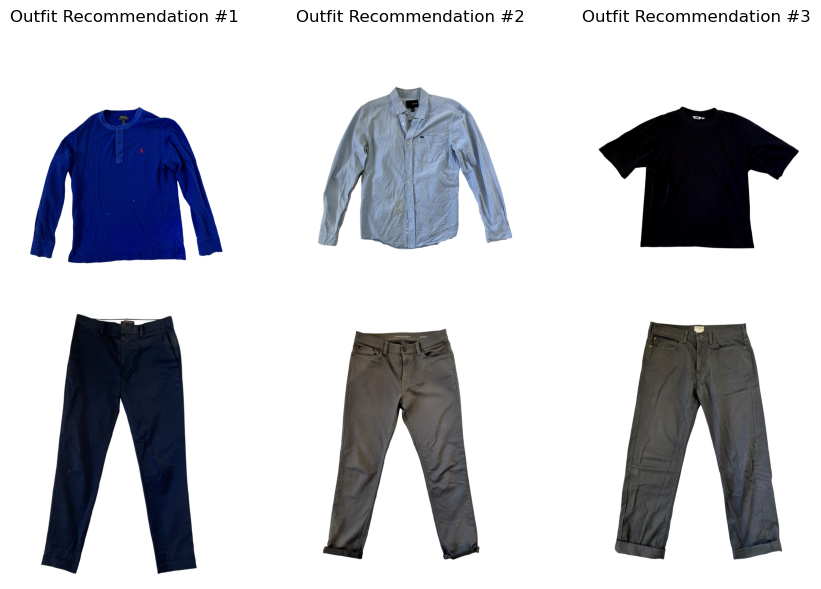


🧠 Your Personal Stylist Says:
Message(id='msg_01ANLpSe3MwHYjCC8mr3r8Pv', content=[TextBlock(citations=None, text="Okay, let's do this! \n\nOutfit 1: This gives off a classic, put-together casual vibe. The blue shirt and navy pants are a nice combo that works well for everyday wear.\n\nOutfit 2: This has a more relaxed, laid-back feel. The blue shirt and khaki pants create a laidback, slightly preppy aesthetic.\n\nOutfit 3: This has a sporty, athleisure-inspired look. The black tee and charcoal pants give off a cool, edgy vibe.\n\nMy final verdict? I'd go with Outfit 2. The blue shirt and khaki pants feel just right for the 18°C weather - casual but still put-together. It's a versatile look that can work for running errands or meeting up with friends. Plus, the colors complement each other really nicely. Outfit 2 gets my vote!", type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(cache_creation_input_

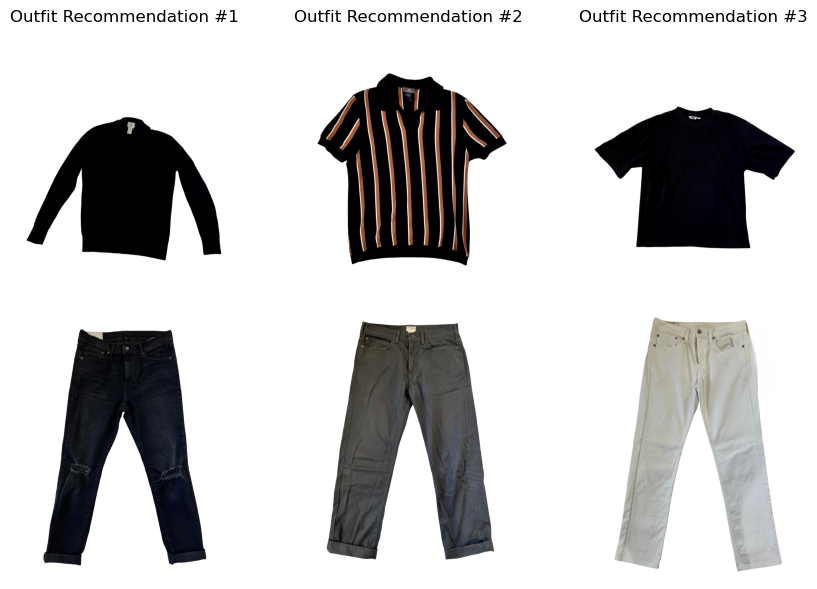


🧠 Your Personal Stylist Says:
Message(id='msg_0191L68Ti7va4qp1hPUtPh4Z', content=[TextBlock(citations=None, text="Okay, let's take a look at these outfits!\n\nOutfit 1:\nThis gives off a sleek, minimalist vibe. The all-black look is classic and chic. It's a great option if you want to feel put-together but still casual.\n\nOutfit 2: \nThis has a bit more of a relaxed, laid-back feel. The short-sleeved shirt and charcoal pants give it a cool, effortless look. This could be good if you want to feel comfy but still stylish.\n\nOutfit 3:\nThis has a sporty, athleisure vibe. The black tee and white pants have a fresh, casual-cool aesthetic. This could be perfect if you want to feel relaxed but still put-together.\n\nOverall, I'd recommend Outfit 1. The all-black look is super sleek and polished, but still casual enough for the 18°C weather. It's a versatile outfit that can work for lots of different occasions. The other two are great too, but Outfit 1 feels the most put-together and stylis

In [ ]:
load_dotenv() # get the api key from .env file
client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))
# huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")
# hf_client = InferenceClient(token=huggingface_api_key)

# Load clothing data and embeddings
with open("Parsa/testing_code/clothing_embeddings.json") as f:
    clothing_data = json.load(f)

metadata_list = []
embedding_list = []

for item in clothing_data:
    metadata_list.append({k: item[k] for k in item if k != "embedding"})
    embedding_list.append(item["embedding"])

embedding_array = np.array(embedding_list).astype("float32")

# Create FAISS index
embedding_dim = embedding_array.shape[1]
faiss_index = faiss.IndexFlatL2(embedding_dim)
faiss_index.add(embedding_array)

# Weather Tool
class WeatherTool:
    def __init__(self):
        self.api_key = "b6d172c255ac43e1ebfa3d041e1c454c"

    def get_temperature(self, city="Washington", country="US"):
        url = f"http://api.openweathermap.org/data/2.5/weather?q={city},{country}&appid={self.api_key}&units=metric"
        response = requests.get(url)
        data = response.json()
        if "main" in data:
            return round(data["main"]["temp"])
        else:
            raise ValueError(f"Failed to fetch weather data: {data}")

# input parser for occasion and colors with specificity
def parse_user_input(user_input):
    user_input = user_input.lower()
    occasion = "casual"  # default

    if any(word in user_input for word in ["date", "romantic"]):
        occasion = "date night"
    elif any(word in user_input for word in ["interview", "meeting"]):
        occasion = "job interview"
    elif any(word in user_input for word in ["beach", "walk"]):
        occasion = "beach walk"
    elif any(word in user_input for word in ["chill", "weekend", "hang"]):
        occasion = "chill weekend hang"
    elif any(word in user_input for word in ["formal"]):
        occasion = "formal"
    elif any(word in user_input for word in ["gym", "run", "sporty"]):
        occasion = "sporty"
    
    # Parse color preferences
    detected_colors = []
    color_target = "top"  # default to top
    
    for color in color_palette:
        if color in user_input:
            detected_colors.append(color)
            
    # Check if the user specified where to apply the color
    if "top" in user_input or "shirt" in user_input or "t-shirt" in user_input:
        color_target = "top"
    elif "bottom" in user_input or "pants" in user_input or "shorts" in user_input:
        color_target = "bottom"
    
    return {
        "occasion": occasion,
        "colors": detected_colors,
        "color_target": color_target
    }

# Improved wardrobe filter with color targeting
def filter_wardrobe(wardrobe, temperature, occasion, color_preferences=None, color_target="both"):
    suitable = []
    
    for item in wardrobe:
        # Handle both string and list formats for item properties
        item_styles = item.get("style", [])
        if isinstance(item_styles, str):
            item_styles = [item_styles]
            
        item_color = item.get("color", "")
        if isinstance(item_color, list):
            item_color = " ".join(item_color)  # Join list of colors into a string
        item_color = item_color.lower()
        
        # Check occasion match
        occasion_match = occasion in item_styles
        
        # Temperature check
        temp_suitable = True
        if temperature < 15:
            if not (item["category"] == "pants" or item.get("sleeve", "") == "long" or item["category"] in ["shirt", "t-shirt"]):
                temp_suitable = False
        
        # Add item if it meets basic criteria (we'll filter by color separately)
        if occasion_match and temp_suitable:
            suitable.append(item)
    
    # If not enough items, try to broaden
    if len(suitable) < 2:
        suitable = [item for item in wardrobe if "casual" in item.get("style", [])]
    
    return suitable

# Generate Recommendations
def generate_outfit_recommendations(user_input, temperature, gender, outfits: List[List[dict]]):
    prompt = f"""
Hey, you're my stylish buddy helping me get dressed.
I'm a {gender} and I'm trying to figure out what to wear.

Here's the situation:
"{user_input}" (temperature is {temperature}°C)

Here are three outfit combos I'm considering:
"""

    for i, outfit in enumerate(outfits):
        prompt += f"\nOutfit {i+1}:\n{json.dumps(outfit, indent=2)}\n"

    prompt += """
For each one, tell me what kind of vibe it gives off — like if I want to feel chill, sporty, bold, etc.
Then give me your final verdict on which one to wear and why. Keep it casual and short, like we're texting.
"""

    try:
        # Correct way to use HuggingFace InferenceClient for text generation
        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=300,
            temperature=0.8,
            messages=[{"role": "user", "content": prompt}]
        )
        # response = hf_client.text_generation(
        #     prompt,
        #     model="mistralai/Mistral-7B-Instruct",
        #     max_new_tokens=300,
        #     temperature=0.8,
        #     repetition_penalty=1.1
        # )
        return [response]
    except Exception as e:
        print(f"Error with Hugging Face API: {e}")
        # Simple fallback response if API fails
        return ["Here's my take on these outfits: They all look good for different reasons. I'd go with outfit #1 because it seems to best match the occasion and weather. Let me know what you think!"]

def display_selected_outfit(outfits):
    category_folder_map = {
        "shirt": "shirts",
        "t-shirt": "t-shirts",
        "pants": "pants",
        "shorts": "shorts"
    }

    num_outfits = len(outfits)
    fig, axs = plt.subplots(2, num_outfits, figsize=(3 * num_outfits, 6), gridspec_kw={'hspace': 0.0})

    for col, outfit in enumerate(outfits):
        for row, item in enumerate(outfit):
            path = os.path.join("Parsa/parsa's_wardrobe", category_folder_map[item["category"]], item["filename"])
            img = Image.open(path).convert("RGB")
            axs[row, col].imshow(img)
            axs[row, col].axis("off")

    for col in range(num_outfits):
        axs[0, col].set_title(f"Outfit Recommendation #{col + 1}", fontsize=12, pad=10)

    plt.subplots_adjust(hspace=0)
    plt.tight_layout()
    plt.show()

# Outfit Agent with color specification prompt
def outfit_agent(user_input, temperature, gender="female", refresh=False, lock_top=None, lock_bottom=None):
    # Parse user input for occasion and colors
    parsed_input = parse_user_input(user_input)
    occasion = parsed_input["occasion"]
    color_preferences = parsed_input["colors"]
    color_target = parsed_input["color_target"]

    print(f"\n🎯 Occasion detected: {occasion}")

    if color_preferences:
        color_str = ", ".join(color_preferences)
        print(f"🎨 Color preferences detected: {color_str}")
        
        # If user specified colors but didn't specify where to apply them, ask for clarification
        if color_target == "both" and not any(word in user_input.lower() for word in ["both", "everything", "all"]):
            print("\n🤔 I noticed you mentioned a specific color. Would you like me to apply this to:")
            print("1. Just the top")
            print("2. Just the bottom")
            print("3. Both pieces")
            
            color_choice = input("Enter your choice (1/2/3): ").strip()
            
            if color_choice == "1":
                color_target = "top"
                print("✅ Applying color to top only.")
            elif color_choice == "2":
                color_target = "bottom"
                print("✅ Applying color to bottom only.")
            else:
                color_target = "both"
                print("✅ Applying color to both pieces.")
    else:
        print("🎨 No specific color preferences detected")

    # Filter wardrobe based on basic criteria first (temperature and occasion)
    filtered = filter_wardrobe(metadata_list, temperature, occasion)
    
    # Create separate lists for tops and bottoms
    all_tops = [item for item in filtered if item["category"] in ["shirt", "t-shirt"]]
    all_bottoms = [item for item in filtered if item["category"] in ["pants", "shorts"]]
    
    # Apply color filter based on target
    if color_preferences:
        if color_target in ["top", "both"]:
            tops = [item for item in all_tops if any(color in item.get("color", "").lower() for color in color_preferences)]
            if not tops:  # Fallback if no matching tops
                tops = all_tops
                print(f"⚠️ No tops found in {color_str}. Showing all suitable tops.")
        else:
            tops = all_tops
            
        if color_target in ["bottom", "both"]:
            bottoms = [item for item in all_bottoms if any(color in item.get("color", "").lower() for color in color_preferences)]
            if not bottoms:  # Fallback if no matching bottoms
                bottoms = all_bottoms
                print(f"⚠️ No bottoms found in {color_str}. Showing all suitable bottoms.")
        else:
            bottoms = all_bottoms
    else:
        tops = all_tops
        bottoms = all_bottoms
    
    # Check if we have enough items
    if len(tops) < 1:
        print("⚠️ Not enough tops found. Adding all tops.")
        tops = [item for item in metadata_list if item["category"] in ["shirt", "t-shirt"]]
    
    if len(bottoms) < 1:
        print("⚠️ Not enough bottoms found. Adding all bottoms.")
        bottoms = [item for item in metadata_list if item["category"] in ["pants", "shorts"]]
    
    if refresh:
        random.shuffle(tops)
        random.shuffle(bottoms)

    combinations = []
    max_outfits = min(3, len(tops), len(bottoms))
    
    if max_outfits == 0:
        print("❌ Error: No outfit combinations possible with available items.")
        return []
        
    for i in range(max_outfits):
        top = lock_top if lock_top else tops[i]
        bottom = lock_bottom if lock_bottom else bottoms[i]
        combinations.append([top, bottom])

    responses = generate_outfit_recommendations(user_input, temperature, gender, combinations)
    
    try:
        display_selected_outfit(combinations)
    except Exception as e:
        print(f"Error displaying outfits: {e}")

    for i, res in enumerate(responses):
        print(f"\n\U0001F9E0 Your Personal Stylist Says:\n{res}\n")

    return combinations

# Chat Loop updated to handle color targeting
def chat_loop():
    combos = []
    locked_top = None
    locked_bottom = None

    print("👗 Welcome to your personal stylist, CASUAL!")
    # print("💡 TIP: You can specify colors for specific pieces like 'blue top with black pants' or just ask for a 'blue outfit'")
    

    # Fetch the temperature once before the loop starts
    weather_tool = WeatherTool()
    cached_temperature = weather_tool.get_temperature("Washington", "US")
    print(f"🌤️ Current temperature in Washington: {cached_temperature}°C")

    while True:
        user_input = input("\n\U0001F464 You: ").strip().lower()

        if user_input in ["exit", "quit", "bye"]:
            print("👋 Bye! Stay stylish.")
            break

        if "show colors" in user_input or "show me the colors" in user_input or "available colors" in user_input:
            print(f"✨ Available colors: {', '.join(sorted(color_palette))}")
            continue

        if "unlock" in user_input:
            if "pants" in user_input or "bottom" in user_input:
                locked_bottom = None
                print("🔓 Unlocked bottoms.")
            if "shirt" in user_input or "top" in user_input:
                locked_top = None
                print("🔓 Unlocked tops.")
            continue

        if "lock" in user_input:
            if "pants" in user_input or "bottom" in user_input:
                try:
                    idx = int(user_input.split("outfit")[-1].strip()) - 1
                    locked_bottom = combos[idx][1]
                    print(f"✅ Bottom locked from Outfit {idx + 1}!")
                except Exception as e:
                    print("❌ Could not lock bottom:", e)
                continue

            if "shirt" in user_input or "top" in user_input:
                try:
                    idx = int(user_input.split("outfit")[-1].strip()) - 1
                    locked_top = combos[idx][0]
                    print(f"✅ Top locked from Outfit {idx + 1}!")
                except Exception as e:
                    print("❌ Could not lock top:", e)
                continue

        # Process the user input and generate outfits
        combos = outfit_agent(
            user_input,
            temperature=cached_temperature,
            refresh=True,
            lock_top=locked_top,
            lock_bottom=locked_bottom
        )
# Run it
if __name__ == "__main__":
    chat_loop()

In [36]:
import json

# Load metadata
with open("Parsa/parsa's_wardrobe/metadata.json") as f:
    metadata = json.load(f)

# Extract and count unique colors
color_set = set()

for category_items in metadata.values():
    for item in category_items:
        color = item.get("color")
        if color:
            color_set.add(color.lower().strip())

print(f"Total distinct colors: {len(color_set)}")
print("Distinct colors:", sorted(color_set))

Total distinct colors: 16
Distinct colors: ['beige', 'black', 'blue', 'brown', 'charcoal', 'gray', 'khaki', 'light blue', 'mustard', 'navy', 'olive', 'orange', 'peach', 'red', 'teal', 'white']
